In [0]:
from nltk.stem.porter import * 

stemmer = PorterStemmer()
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']

# deacc=True removes punctuation
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(sentence, deacc=True))

# We will generate topics for a specific party_group. The below function takes a party name and applies preprocessing
# only for the speeches belonging to the party. This will also speed up the processing. It will return preprocessed
# word tokens
# Following preprocessing is done 
# Remove Punctuation -> Remove Stopwords -> Stemming -> Lemmatization

def preprocess_data(partyname):
  text = hansard_train['speech'][hansard_train['party_group'] == partyname]
  # remove punctuation and tokenize the words
  token_lists = list(sent_to_words(text))
  # remove stopwords and stem the words
  cleaned_tokens = [[stemmer.stem(word) for word in tokens if word not in stop_words] for tokens in token_lists]
  # Do lemmatization keeping only noun, adj, vb, adv
  cleaned_tokens = [[token.lemma_ for token in nlp(" ".join(x)) if token.pos_ in allowed_postags] for x in cleaned_tokens]
  return cleaned_tokens

cleaned_speeches = preprocess_data('Labour')

## **Stance Detection**

In [0]:
!pip install tensorflow==2.0.0

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

hansard = pd.read_csv('HanDeSeT.csv')
print('Dataset Size: ', hansard.shape)
hansard.head()

Dataset Size:  (1251, 16)


,id,title,motion,manual motion,govt/opp motion,motion party affiliation,utt1,utt2,utt3,utt4,utt5,manual speech,vote speech,party affiliation,name,rebellion %
0,1,Doctor Assisted Dying,That leave be given to bring in a Bill to enab...,1,1,Lab,I trust that the House will not feel that ther...,If one considers the argument from a religious...,I accept that we shall all face death at one t...,"When we listen to my hon. Friend's case, we mu...",I do not think that we want that sort of socie...,0,0,Lab,Kevin McNamara,3.2
1,2,Local Government Finance (Scotland),That the Local Government Finance (Scotland) O...,1,1,Lab,The Secretary State talks of the lack of fuss ...,The right hon. Gentleman may not have heard fu...,North Tayside.,The Secretary of State's geography is terrible.,Would not the £40 million gap in the assumptio...,0,0,SNP,John Swinney,0.4
2,2,Local Government Finance (Scotland),That the Local Government Finance (Scotland) O...,1,1,Lab,May I assure the right hon. Gentleman that he ...,Will the hon. Gentleman clarify what he meant ...,NaN,NaN,NaN,1,1,Lab,John McAllion,4.5
3,2,Local Government Finance (Scotland),That the Local Government Finance (Scotland) O...,1,1,Lab,"Is the hon. Gentleman aware that, ever since t...","I rise as one who, in the past, has not been a...",It would be inappropriate to allow the debate ...,"Why are the problems of so many of our people,...",Today's debate is the first of this sort under...,0,1,Lab,Ian Davidson,3.1
4,2,Local Government Finance (Scotland),That the Local Government Finance (Scotland) O...,1,1,Lab,The hon. Gentleman will notice that the Childr...,I thank the hon. Gentleman for his generosity ...,NaN,NaN,NaN,1,1,Lab,Maria Fyfe,2.3


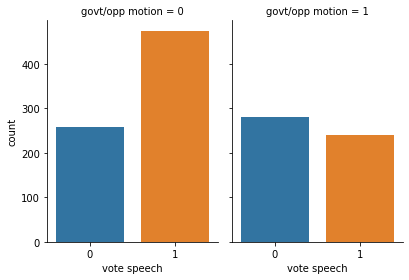

In [0]:
sns.catplot(x='vote speech', col='govt/opp motion', data=hansard, kind="count", height=4, aspect=.7)


In [0]:
hansard.groupby(['govt/opp motion', 'vote speech']).size()

govt/opp motion  vote speech
0                0              258
                 1              474
1                0              280
                 1              239
dtype: int64

**Pre-processing data**

Pre-processing
1. Drop unused columns - title, manual motion, manual speech, name, rebellion%
2. Combine 'utterances' columns to form a new 'speech' column
3. Remove  and proper nouns
4. Convert the text to lowercase
5. Remove punctuation, numbers, special characters
6. Remove removal_words list. We will use a manually defined list of words which contains articles, prepositions, 'months' and common words used in hansard speech like 'hon gentleman'. We are not using prefined stopwords lists from the python libraries because those lists contain words like 'not', 'dont', 'certainly' etc which are useful for stance prediction and should not be removed. Some words from the list are taken from this link and updated. https://gist.github.com/sebleier/554280
7. Convert party labels to integers

Feature creation 
(papers referred: https://www.aclweb.org/anthology/S17-2080.pdf, https://www.aclweb.org/anthology/W10-0214.pdf)
1. Find the Vader Sentiment compund score for motion and speech text
2. Count the number of question words in speech text (question words generally indicate arguments.)
3. Word Count of Speeches
3. Count number of positive and negative arguing words using arguing lexicon  #To-Do later


We calculate count of question words and arguing words only for speech text and not motion text as motions are plain sentences in the dataset.

In [0]:
! pip install vaderSentiment

In [3]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

def preprocess_data(hansard):

  # Drop unused columns 
  hansard = hansard.drop(hansard.columns[[1, 3, 11, 14, 15]], axis=1) 

  # Combine the Utterances and create a new column named 'speech' -> easier for processing
  cols = ['utt1', 'utt2', 'utt3', 'utt4', 'utt5']
  hansard["speech"] = hansard[cols].apply(lambda x: ','.join(x.dropna()), axis=1)

  # drop utterance columns
  hansard = hansard.drop(cols, axis=1) 

  removal_words = ["a", "am", "an", "and", "any","are", "as", "at", "by", "did", "from", "he", "her", "here", \
             "hers", "herself", "him", "himself", "his", "hon", "i", "in", "into", "is", "it", "it's", "its", \
             "itself", "ll", "m", "may", "me", "my", "myself", "now", "o", "of", "on", "once", "or", "other", "our", "ours", "ourselves", \
             "re", "s", "she", "she's", "so", "such", "t", "that", "that'll", "the", "their", "theirs", \
             "them", "themselves", "then", "there", "these", "they", "this", "those", "to", "ve", "was", \
             "we", "were", "with", "y", "you", "youd", "youll", "will", "government", "member",\
             "you're", "you've", "your", "yours", "yourself", "yourselves", "hed", "he'll", "hes", "heres", "hows", "i'd",\
             "i'll", "im", "ive", "lets", "she'd", "she'll", "thats", "there's", "theyd", "theyll", "theyre", "theyve", "we'd",\
             "we'll", "were", "weve", "gentleman", "friend", "house", "minister", "people", "january",\
             "february", "march", "april", "may", "june", "july", "august", "september", "october", "november", "december", "jan", "feb", "mar", \
             "apr", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]

  # Since we are predicting sentiment(stance) given the motion statement, it is essential to include features from the motion text to identify whether the motion is positive or negative.
  # We will clean both motion and speech text
  # Motion text contains numbers and some extra information in brackets which is just plain text and does not express any emotion. So the bracketed text and numbers will be removed
  hansard['cleaned_motion'] = hansard['motion'].apply(lambda x: ' '.join([word for word, tag in pos_tag(x.split()) if tag != 'NNP' or tag != 'NNPS']))
  hansard['cleaned_motion'] = hansard['cleaned_motion'].str.lower()
  hansard['cleaned_motion'] = hansard['cleaned_motion'].str.replace("\(.*\)", "")
  hansard['cleaned_motion'] = hansard['cleaned_motion'].str.replace("[^a-zA-Z ]", "") 
  hansard['cleaned_motion'] = hansard['cleaned_motion'].apply(lambda x: ' '.join([word for word in x.split() if (word not in removal_words) and len(word)>1]))

  # Cleaning speech text
  hansard['cleaned_speech'] = hansard['speech'].apply(lambda x: ' '.join([word for word, tag in pos_tag(x.split()) if tag != 'NNP' or tag != 'NNPS']))
  hansard['cleaned_speech'] = hansard['cleaned_speech'].str.lower()
  hansard['cleaned_speech'] = hansard['cleaned_speech'].str.replace("[^a-zA-Z ]", "") 
  hansard['cleaned_speech'] = hansard['cleaned_speech'].apply(lambda x: ' '.join([word for word in x.split() if (word not in removal_words) and len(word)>1]))

  # drop speech and motion columns
  hansard = hansard.drop(['motion', 'speech'], axis=1) 

  # Let us convert the party labels to integer 
  motion_party = {'Lab': 1, 'Con': 2, 'SNP': 3, 'DUP': 4, 'LD':5}
  party = {'Lab': 1, 'Con': 2, 'SNP': 3, 'DUP': 4, 'LD':5, 'SDLP': 6, 'IndUU': 6, 'UUP': 6, 'IndSN': 6, 'Green': 6, 'PC': 6, 'IndCon': 6, 'IndLab': 6}

  hansard['motion party affiliation'] = hansard['motion party affiliation'].apply(lambda x: motion_party[x])
  hansard['party affiliation'] = hansard['party affiliation'].apply(lambda x: party[x])

  # New feature creation
  # 1. question word count
  hansard['speech_ques_words'] = hansard['cleaned_speech'].str.count(r'(what)|(when)|(where)|(which)|(who)|(whom)|(why)|(whose)|(how)')

  # 2. vader sentiment compund score
  analyser = SentimentIntensityAnalyzer()
  hansard['motion_score'] = hansard['cleaned_motion'].apply(lambda x: (analyser.polarity_scores(x))['compound'])
  hansard['speech_score'] = hansard['cleaned_speech'].apply(lambda x: (analyser.polarity_scores(x))['compound'])

  # 3. speech word count
  hansard['speech_word_count'] = hansard['cleaned_speech'].apply(lambda x: len([w for w in x.split()]))

  return hansard

hansard = preprocess_data(hansard)
hansard.head()
  

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


,id,govt/opp motion,motion party affiliation,vote speech,party affiliation,cleaned_motion,cleaned_speech,speech_ques_words,motion_score,speech_score,speech_word_count
0,1,1,1,0,1,leave be given bring bill enable person who su...,trust not feel lack compassion side argument a...,14,-0.8555,-0.9983,353
1,2,1,1,0,3,local finance order dated th copy which laid b...,secretary state talks lack fuss about local se...,4,0.4215,0.5859,116
2,2,1,1,1,1,local finance order dated th copy which laid b...,assure right probably alone thinking sad matte...,4,0.4215,-0.7269,59
3,2,1,1,1,1,local finance order dated th copy which laid b...,aware ever since beginning urban aid programme...,10,0.4215,0.9781,289
4,2,1,1,1,1,local finance order dated th copy which laid b...,notice children scotland act enacted has been ...,2,0.4215,0.6748,111


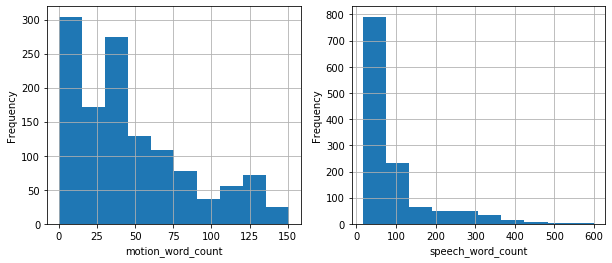

In [0]:
motion_word_count = hansard['cleaned_motion'].apply(lambda x: len([w for w in x.split()]))
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
motion_word_count.hist(ax=axes[0])
hansard['speech_word_count'].hist(ax=axes[1])
x_labels = ['motion_word_count', 'speech_word_count']
i = 0
for ax in axes:
  ax.yaxis.grid(True)
  ax.set_xlabel(x_labels[i])
  ax.set_ylabel('Frequency')
  i = i + 1

# **Classification Models and Feature selection**
We will build the following models
1. Support Vector Machines
2. Neural Netowrks

We will analyze the prediction accuracy of models 
1. Text data will be converted to following representations - token combination of 1,2,3 grams
   1. Bag of Words (SVMs)
   2. TF-IDF (SVMs, Neural Networks)
   3. Glove (Neural Networks)

2. Extra available features along with Speech column. 
   The features are (References: https://www.aclweb.org/anthology/L18-1659.pdf)
   1. Debate id -> . As there are usually multiple speeches in each debate, and MPs will often express similar sentiments to members of their own party in a particular debate, we also follow Salah (2014) in including this feature to capture possible correlations between MPs’ speech and voting behaviour.
   2. Speaker party affiliation -> Intuition suggests
that a speaker’s party membership should be
a strong indicator of sentiment towards many
topics, and Salah (2014) showed this to be the
case, at least as far as correlation with speakers’ division votes goes
   3. Motion party affiliation. Because MPs are
likely to be more or less supportive of a motion depending on who proposes it, we add that Member’s party as a further contextual feature.
   4. Govt/Oppo Motion 

3. Newly created features
  1. Vader sentiment score
  2. Count of question words
  3. Count of words in speech text
 

   Papers and websites referred for neural networks implemetation
1. https://www.aclweb.org/anthology/L18-1659.pdf
2. https://arxiv.org/pdf/1510.03820.pdf
3. https://www.aclweb.org/anthology/W19-4621.pdf
4. https://link.springer.com/article/10.1007/s12065-019-00227-4
5. https://machinelearningmastery.com
6. http://www.davidsbatista.net/blog/2018/03/31/SentenceClassificationConvNets/
    

Let us draw WordClouds and find the frequest words in positive and negative speeches

In [0]:
def create_wordcloud(label):
  # combine all the tweets and build a wordCloud for 'Labour' party
  text = ' '.join([sent for sent in hansard['cleaned_speech'][hansard['vote speech'] == label]])
  wordcloud = WordCloud(width=400, height=300, random_state=21, max_font_size=110).generate(text)
  plt.figure(figsize=(10, 7)) 
  plt.imshow(wordcloud, interpolation="bilinear") 
  plt.axis('off')


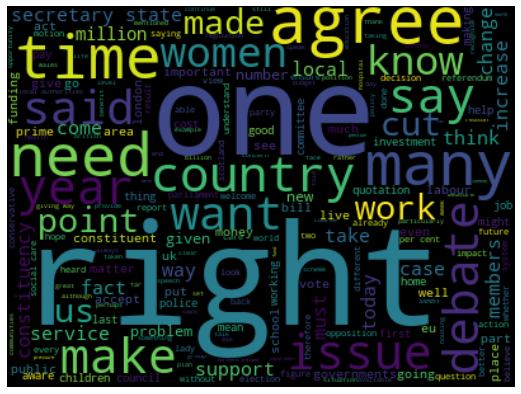

In [0]:
create_wordcloud(1)

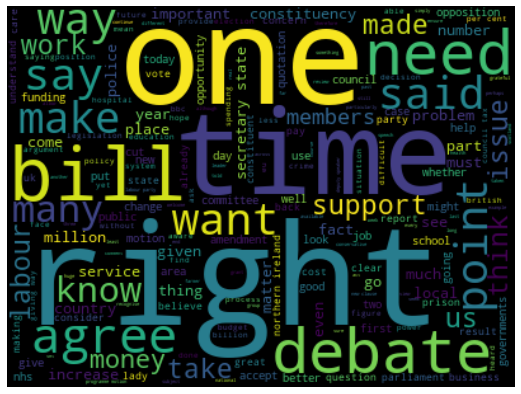

In [0]:
create_wordcloud(0)

We will split the data into 90% train and 10% test set

In [0]:
x_train, x_test, y_train, y_test = train_test_split(hansard, hansard['vote speech'], test_size=0.1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

del hansard

(1125, 11)
(1125,)
(126, 11)
(126,)


Let's create Bag Of Words and TF-IDF features

In [0]:
from scipy.sparse import csr_matrix, hstack

def add_feature(X, Y, feature_to_add):
    """
    Returns sparse feature matrix with added feature.
    feature_to_add can also be a list of features.
    """
    return hstack([X, Y, csr_matrix(feature_to_add).T], 'csr')

In [0]:
bow_vectorizer_motion = CountVectorizer(max_df=0.85, min_df=2, ngram_range=(1,3))
bow_vectorizer_speech = CountVectorizer(max_df=0.90, min_df=5, ngram_range=(1,3)) 
bow_motion = bow_vectorizer_motion.fit_transform(x_train['cleaned_motion']) 
bow_motion_test = bow_vectorizer_motion.transform(x_test['cleaned_motion'])
bow_speech = bow_vectorizer_speech.fit_transform(x_train['cleaned_speech']) 
bow_speech_test = bow_vectorizer_speech.transform(x_test['cleaned_speech'])

tfidf_vectorizer_motion = TfidfVectorizer(max_df=0.85, min_df=2, ngram_range=(1,3))
tfidf_vectorizer_speech = TfidfVectorizer(max_df=0.90, min_df=5, ngram_range=(1,3)) 
tfidf_motion = tfidf_vectorizer_motion.fit_transform(x_train['cleaned_motion']) 
tfidf_motion_test = tfidf_vectorizer_motion.transform(x_test['cleaned_motion'])
tfidf_speech = tfidf_vectorizer_speech.fit_transform(x_train['cleaned_speech']) 
tfidf_speech_test = tfidf_vectorizer_speech.transform(x_test['cleaned_speech'])

bow = add_feature(bow_motion, bow_speech, [x_train['id'], x_train['motion party affiliation'], x_train['govt/opp motion'], x_train['party affiliation'], x_train['speech_ques_words'], x_train['motion_score'],	x_train['speech_score'], x_train['speech_word_count']])
bow_test = add_feature(bow_motion_test, bow_speech_test, [x_test['id'], x_test['motion party affiliation'], x_test['govt/opp motion'], x_test['party affiliation'], x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'], x_test['speech_word_count']])
tfidf = add_feature(tfidf_motion, tfidf_speech, [x_train['id'], x_train['motion party affiliation'], x_train['govt/opp motion'], x_train['party affiliation'], x_train['speech_ques_words'], x_train['motion_score'],	x_train['speech_score'], x_train['speech_word_count']])
tfidf_test = add_feature(tfidf_motion_test, tfidf_speech_test, [x_test['id'], x_test['motion party affiliation'], x_test['govt/opp motion'], x_test['party affiliation'], x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'],  x_test['speech_word_count']])

print('BOW train matrix shape: ', bow.shape)
print('BOW test matrix shape: ', bow_test.shape)
print('TF-IDF train matrix shape: ', tfidf.shape)
print('TF-IDF test matrix shape: ', tfidf_test.shape)

BOW train matrix shape:  (1125, 13797)
BOW test matrix shape:  (126, 13797)
TF-IDF train matrix shape:  (1125, 13797)
TF-IDF test matrix shape:  (126, 13797)


In [0]:
from sklearn.metrics import auc

def plot_roc_curve(fpr, tpr):
  lw = 2
  area = auc(fpr, tpr)
  plt.plot(fpr, tpr, color='darkorange',
          lw=lw, label='ROC curve (area = %0.2f)' % area)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic example')
  plt.legend(loc="lower right")
  plt.show()


Support Vector Machines using BOW and TF-IDF features (and additional features as mentioned above). We are using cross-validation to find the best regularization value

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve

def find_best_reg(inverse_lambda, train_data, train_labels):
  mean_scores = []
  for reg in inverse_lambda:
    svm = SVC(C=reg, gamma='scale')
    all_scores = cross_val_score(svm, train_data, train_labels, cv=5, scoring='f1')
    mean_scores.append(all_scores.mean())
  return mean_scores


def svm_predict(reg, train_data, train_labels, test_data):
  final_svm = SVC(C=reg, gamma='scale')
  final_svm.fit(train_data, train_labels)
  y_pred_svm = final_svm.predict(test_data)
  return y_pred_svm



Support Vector Classifier using BOW features

Mean Scores:  [0.7266529024823546, 0.7266529024823546, 0.7266529024823546, 0.6868886352836139, 0.7275321199337901, 0.7303843656183212, 0.7252350524223904, 0.7250176453803754, 0.7251896783443887, 0.7238127136021874, 0.723351618959256, 0.7241305191424872, 0.722183394173426]


Text(0, 0.5, 'Mean Scores')

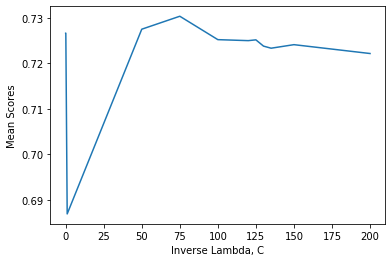

In [0]:
inverse_lambda = [0.001, 0.01, 0.1, 1, 50, 75, 100, 120, 125, 130, 135, 150, 200]
mean_scores = find_best_reg(inverse_lambda, bow, y_train)
print('Mean Scores: ', mean_scores)
plt.plot(inverse_lambda, mean_scores)
plt.xlabel('Inverse Lambda, C')
plt.ylabel('Mean Scores')

Confusion Matrix:
 [[28 27]
 [17 54]]
F1-score:  0.7105263157894737
ROC_AUC_score:  0.6348271446862995


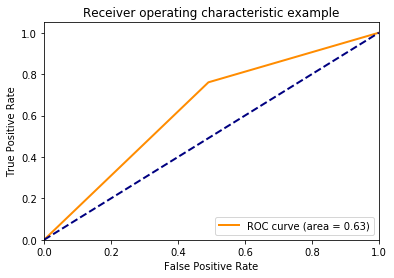

In [0]:
y_pred_svm = svm_predict(75, bow, y_train, bow_test)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_svm))
print('F1-score: ', f1_score(y_test, y_pred_svm))
print('ROC_AUC_score: ', roc_auc_score(y_test, y_pred_svm))
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
plot_roc_curve(fpr, tpr)

Support Vector Classifier using TF-IDF features

Mean Scores:  [0.7310376466589454, 0.732326228145216, 0.7424114001943872, 0.7467101771307352, 0.747760867510341, 0.7505091920681146, 0.7490221586972827, 0.7484700684517618, 0.7490148265734813, 0.7479957686485206, 0.7444120117853759, 0.7378667714822944]


Text(0, 0.5, 'Mean Scores')

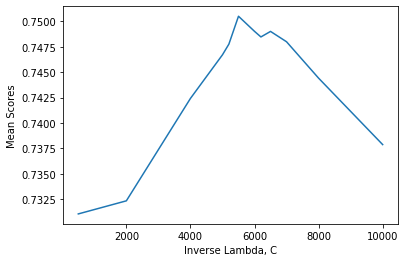

In [0]:
inverse_lambda = [500, 2000, 4000, 5000, 5200, 5500, 6000, 6200, 6500, 7000, 8000, 10000]
mean_scores = find_best_reg(inverse_lambda, tfidf, y_train)
print('Mean Scores: ', mean_scores)
plt.plot(inverse_lambda, mean_scores)
plt.xlabel('Inverse Lambda, C')
plt.ylabel('Mean Scores')

Confusion Matrix:
 [[36 19]
 [16 55]]
F1-score:  0.7586206896551724
ROC_AUC_score:  0.7145966709346991


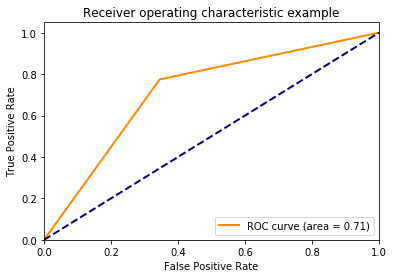

In [0]:
y_pred_svm = svm_predict(5500, tfidf, y_train, tfidf_test)
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred_svm))
print('F1-score: ', f1_score(y_test, y_pred_svm))
print('ROC_AUC_score: ', roc_auc_score(y_test, y_pred_svm))
fpr, tpr, _ = roc_curve(y_test, y_pred_svm)
plot_roc_curve(fpr, tpr)

In [0]:
del bow, bow_motion, bow_speech, bow_speech_test, bow_test, bow_motion_test
del tfidf_motion, tfidf_speech, tfidf_motion_test, tfidf_speech_test

Lets build a simple simple MLP model to predict the sentiment of encoded in speeches. But first we will also create a validation set to be used for the neural networks to tune the hyperparameters. <br/>
We will split the train set again into 10% validation (used only 10% since dataset is small) and 90% train set 

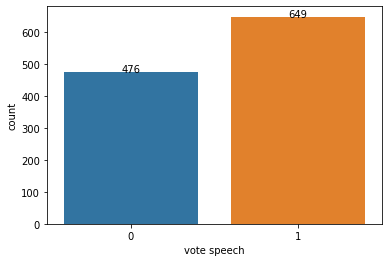

In [0]:
graph = sns.countplot(x='vote speech', data=x_train)
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

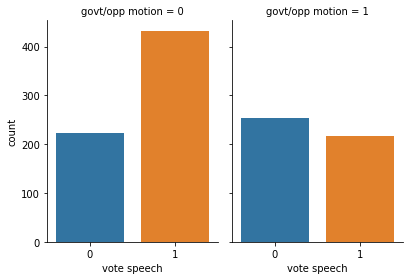

In [0]:
sns.catplot(x='vote speech', col='govt/opp motion', data=x_train, kind="count", height=4, aspect=.7)


In [0]:
import warnings
warnings.filterwarnings("ignore")

from keras.preprocessing.text import Tokenizer
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Embedding, concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Bidirectional
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub

In [0]:
def nn_model_1(num_neurons):
  model = tf.keras.Sequential([
          tf.keras.layers.Dense(num_neurons, activation='relu',  kernel_initializer='he_normal'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dense(num_neurons, activation='relu', kernel_initializer='he_normal'),        
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.BatchNormalization(),
          tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
  return model


In [0]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.metrics import make_scorer, precision_score, recall_score, accuracy_score, roc_auc_score

model_CV = KerasClassifier(build_fn=nn_model_1, epochs=200, batch_size=250, verbose=0)
# define the grid search parameters

num_neurons = [50, 75, 100, 120, 150, 200, 250]

scores = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'auc':make_scorer(roc_auc_score)
}
param_grid = dict(num_neurons=num_neurons)
grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, cv=4, refit='auc' , scoring = scores)
grid_result = grid.fit(tfidf.toarray(), y_train, verbose=0)


In [0]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_auc']
stds = grid_result.cv_results_['std_test_auc']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.673786 using {'num_neurons': 250}
0.663391 (0.018987) with: {'num_neurons': 50}
0.655906 (0.026580) with: {'num_neurons': 75}
0.653613 (0.007361) with: {'num_neurons': 100}
0.643476 (0.035481) with: {'num_neurons': 120}
0.646274 (0.034416) with: {'num_neurons': 150}
0.656851 (0.018106) with: {'num_neurons': 200}
0.673786 (0.023714) with: {'num_neurons': 250}


Confusion Matrix:
 [[41 16]
 [18 51]]
F1-score:  0.75
ROC_AUC_score:  0.7292143401983219


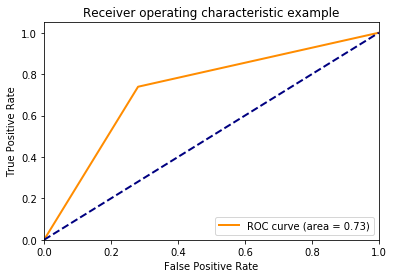

In [0]:
y_pred = grid_result.predict(tfidf_test.toarray())
print('Confusion Matrix:\n', confusion_matrix(y_test, y_pred))
print('F1-score: ', f1_score(y_test, y_pred))
print('ROC_AUC_score: ', roc_auc_score(y_test, y_pred))
fpr, tpr, _ = roc_curve(y_test, y_pred)
plot_roc_curve(fpr, tpr)

In [0]:
xtrain = hstack([tfidf_motion, tfidf_speech], 'csr')
xtest = hstack([tfidf_motion_test, tfidf_speech_test], 'csr')

xtrain, xval, ytrain, yval = train_test_split(xtrain, x_train['vote speech'], test_size=0.1, random_state=42)
print(xtrain.shape)
print(ytrain.shape)
print(xval.shape)
print(yval.shape)
print(xtest.shape)
print(y_test.shape)

ytrain = np.array(ytrain)
ytest = np.array(y_test)
yval = np.array(yval)

xtrain2 = add_feature(None, None, [x_train['id'], x_train['motion party affiliation'], x_train['party affiliation'], x_train['govt/opp motion'], x_train['speech_ques_words'], x_train['motion_score'], x_train['speech_score'], x_train['speech_word_count']])
xtrain2, xval2, _, _ = train_test_split(xtrain2, x_train['vote speech'], test_size=0.1, random_state=42)
xtest2 = add_feature( None, None, [x_test['id'], x_test['motion party affiliation'], x_test['party affiliation'], x_test['govt/opp motion'],x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'], x_test['speech_word_count']])

length2 = xtrain2.shape[1]

(1012, 13789)
(1012,)
(113, 13789)
(113,)
(126, 13789)
(126,)


In [0]:
# reshape data to feed into LSTM
xtrain = xtrain.toarray()
xval = xval.toarray()
xtest = xtest.toarray()
xtrain = xtrain.reshape(xtrain.shape[0], 1, xtrain.shape[1])
xval = xval.reshape(xval.shape[0], 1, xval.shape[1])
xtest = xtest.reshape(xtest.shape[0], 1, xtest.shape[1])
ytrain = ytrain.reshape(ytrain.shape[0], 1)
yval = yval.reshape(yval.shape[0], 1)
ytest = ytest.reshape(ytest.shape[0], 1)

In [0]:
def nn_model_2(n_neurons, length2, metrics):
  # channel 1
  inputs1 = Input(shape=(1, xtrain.shape[2]))
  lstm1 = Bidirectional(LSTM(7, input_shape=(1, xtrain.shape[2]), recurrent_dropout=0.5, return_sequences=True))(inputs1)
  drop1 = Dropout(rate=0.5)(lstm1)
  flat1 = Flatten()(drop1)
  dense1 = Dense(1, activation='relu')(flat1)

  # channel 2
  inputs2 = Input(shape=(length2,))
  dense2 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(inputs2)
  drop2 = Dropout(rate=0.7)(dense2)
  bn2 = BatchNormalization()(drop2)

  # merge
  merged = concatenate([dense1, bn2])

  # shared
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(merged)
  drop3 = Dropout(rate=0.5)(dense3)
  bn3 = BatchNormalization()(drop3)
  outputs = Dense(1, activation='sigmoid')(bn3)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics)
  return model

In [0]:
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
model = nn_model_2(75, length2, metrics)
history = model.fit([xtrain, xtrain2.toarray()], ytrain, epochs=80, batch_size=300, validation_data=([xval, xval2.toarray()], yval), shuffle=True, callbacks=[checkpoint], verbose=1)

Train on 1012 samples, validate on 113 samples
Epoch 1/80
1012/1012 [==============================] - 6s 6ms/sample - loss: 0.8843 - accuracy: 0.5178 - precision: 0.5947 - recall: 0.5340 - auc: 0.5069 - val_loss: 1.1480 - val_accuracy: 0.5841 - val_precision: 0.6596 - val_recall: 0.5000 - val_auc: 0.6033
Epoch 2/80
1012/1012 [==============================] - 0s 333us/sample - loss: 0.8312 - accuracy: 0.5119 - precision: 0.5887 - recall: 0.5306 - auc: 0.5255 - val_loss: 0.9028 - val_accuracy: 0.6106 - val_precision: 0.6667 - val_recall: 0.5806 - val_auc: 0.6052
Epoch 3/80
1012/1012 [==============================] - 0s 344us/sample - loss: 0.8361 - accuracy: 0.5217 - precision: 0.5925 - recall: 0.5663 - auc: 0.5131 - val_loss: 0.7982 - val_accuracy: 0.6195 - val_precision: 0.6727 - val_recall: 0.5968 - val_auc: 0.6078
Epoch 4/80
1012/1012 [==============================] - 0s 276us/sample - loss: 0.8308 - accuracy: 0.5148 - precision: 0.5861 - recall: 0.5612 - auc: 0.4961 - val_loss: 

In [0]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['figure.figsize'] = (12, 10)
def plot_metrics(history):
  metrics =  ['loss', 'accuracy','auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,3,n+1)
    plt.plot(history.epoch,  history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend()

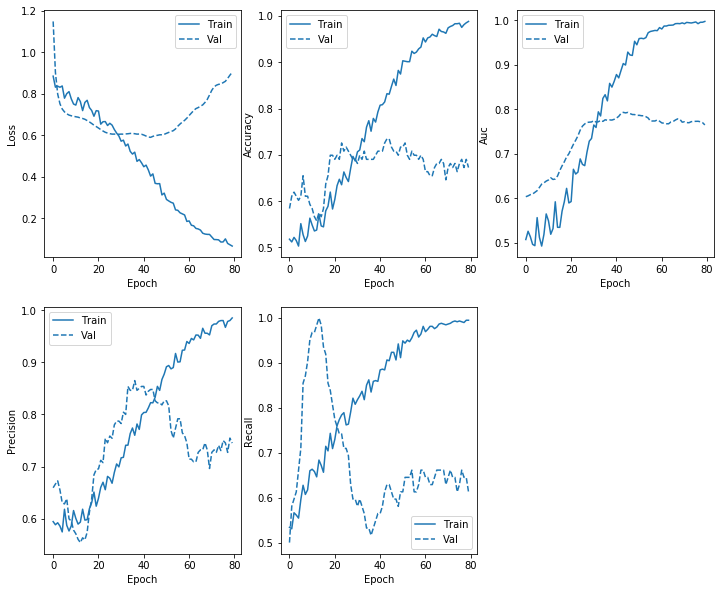

In [0]:
plot_metrics(history)

In [0]:
model.load_weights("best_model.hdf5")
results = model.evaluate([xtest, xtest2.toarray()], ytest, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.6733631576810565
accuracy :  0.6984127
precision :  0.75510204
recall :  0.5873016
auc :  0.70660114



In [0]:
#x_train['motion_speech'] = x_train['cleaned_motion'] + x_train['cleaned_speech']
#x_test['motion_speech'] = x_test['cleaned_motion'] + x_test['cleaned_speech']
x_old = x_train
x_train, x_val, y_train, y_val = train_test_split(x_train, x_train['vote speech'], test_size=0.1)
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1012, 11)
(1012,)
(126, 11)
(126,)


In [0]:
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

TF-IDF + Embedding (Glove pretrained)

In [0]:
# Preparing text for Embedding layer
def create_embedding_text(tokenizer, train, val, test):
  max_length = max([len(sent.split()) for sent in train])
  train_sequences = tokenizer.texts_to_sequences(train)
  train_padded = pad_sequences(train_sequences, padding='pre', maxlen=max_length)
  validation_sequences = tokenizer.texts_to_sequences(val)
  validation_padded = pad_sequences(validation_sequences, padding='pre', maxlen=max_length)
  test_sequences = tokenizer.texts_to_sequences(test)
  test_padded = pad_sequences(test_sequences, padding='pre', maxlen=max_length)
  return (train_padded, validation_padded, test_padded, max_length)

tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(x_old['cleaned_motion'] + x_old['cleaned_speech'])
word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1

#Xtrain1, Xval1, Xtest1, length1, vocab1, word_index = create_embedding_text(x_old['motion_speech'], x_train['motion_speech'], x_val['motion_speech'], x_test['motion_speech'])
Xtrain1, Xval1, Xtest1, length1 = create_embedding_text(tokenizer, x_train['cleaned_motion'], x_val['cleaned_motion'], x_test['cleaned_motion'])
Xtrain2, Xval2, Xtest2, length2 = create_embedding_text(tokenizer, x_train['cleaned_speech'], x_val['cleaned_speech'], x_test['cleaned_speech'])
Xtrain3 = add_feature(None, None, [x_train['id'], x_train['motion party affiliation'], x_train['party affiliation'], x_train['govt/opp motion'], x_train['speech_ques_words'], x_train['motion_score'], x_train['speech_score'], x_train['speech_word_count']])
Xval3 = add_feature(None, None, [x_val['id'], x_val['motion party affiliation'], x_val['party affiliation'], x_val['govt/opp motion'], x_val['speech_ques_words'], x_val['motion_score'], x_val['speech_score'], x_val['speech_word_count']])
Xtest3 = add_feature( None, None, [x_test['id'], x_test['motion party affiliation'], x_test['party affiliation'], x_test['govt/opp motion'],x_test['speech_ques_words'], x_test['motion_score'],	x_test['speech_score'], x_test['speech_word_count']])
length3 = Xtrain3.shape[1]



In [0]:
EMBEDDING_DIM = 100
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.array(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

"""speech_embedding_matrix = np.zeros((len(speech_word_index) + 1, EMBEDDING_DIM))
for word, i in speech_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        speech_embedding_matrix[i] = embedding_vector"""

embedding_motion = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=length1,
                            trainable=False)


embedding_speech = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=length2,
                            trainable=False)



In [0]:
def nn_model_2(neurons, n_neurons, length1, length2, length3, metrics):
  # channel motion
  inputs1 = Input(shape=(length1,))
  #embedding1 = embedding_motion(inputs1)
  #embedding1 = Embedding(vocab_size, 100)(inputs1)
  #lstm1 = LSTM(4)(embedding1)
  lstm1 = LSTM(neurons, batch_input_shape=(250, tfidf_motion.shape[1], tfidf_motion.shape[2]))(inputs1)
  drop1 = Dropout(0.5)(lstm1)
  bn1 = BatchNormalization()(drop1) 
  flat1 = Flatten()(bn1)

  # channel speech
  inputs2 = Input(shape=(length2,))
  #embedding2 = embedding_speech(inputs2)
  #embedding2 = Embedding(vocab_size, 100)(inputs2)
  lstm2 = tf.keras.layers.Bidirectional(LSTM(neurons, batch_input_shape=(250, tfidf_speech.shape[1], tfidf_speech.shape[2]), return_sequences=True, recurrent_dropout=0.7))(inputs2)
  #drop2 = Dropout(0.7)(lstm2)
  #lstm3 = tf.keras.layers.Bidirectional(LSTM(15, return_sequences=True))(drop2)
  #drop3 = Dropout(0.5)(lstm3)
  #bn2 = BatchNormalization()(lstm2) 
  flat2 = Flatten()(lstm2)

  
  # channel 4
  inputs3 = Input(shape=(length3,))
  dense3 = Dense(n_neurons, activation='relu', kernel_initializer="he_normal")(inputs3)
  drop3 = Dropout(rate=0.7)(dense3)
  bn3 = BatchNormalization()(drop3)

  # merge
  merged = concatenate([flat1, flat2, bn3])

  # shared
  dense5 = Dense(n_neurons/2, activation='relu', kernel_initializer="he_normal")(merged)
  drop5 = Dropout(rate=0.5)(dense5)
  bn5 = BatchNormalization()(drop5)
  outputs = Dense(1, activation='sigmoid')(bn5)
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics)
  return model



In [0]:
tfidf_motion.shape

(1012, 1, 9453)

In [0]:

tfidf_motion = tfidf_motion.reshape(tfidf_motion.shape[0], 1, tfidf_motion.shape[1])
tfidf_speech = tfidf_speech.reshape(tfidf_speech.shape[0], 1, tfidf_speech.shape[1])

In [0]:
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
model = nn_model_2(20, 75, length1, length2, length3, metrics)
checkpoint = tf.keras.callbacks.ModelCheckpoint('best_model.hdf5', monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
history = model.fit([tfidf_motion, tfidf_speech, Xtrain3.toarray()], y_train, epochs=50, batch_size=250, validation_data=([tfidf_motion_test.toarray(), tfidf_speech_test.toarray(), Xval3.toarray()], y_val), shuffle=True, callbacks=[earlyStopping, checkpoint], verbose=1)

ValueError: ignored

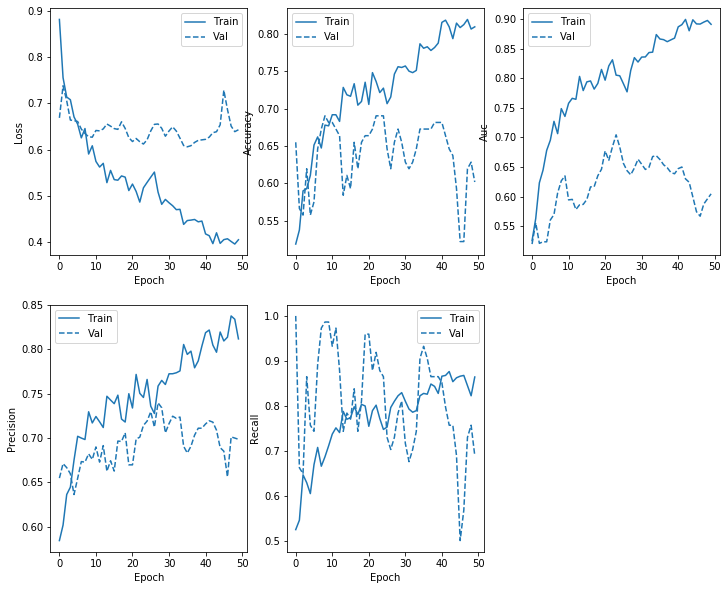

In [0]:

plot_metrics(history)

In [0]:
model.load_weights("best_model.hdf5")
results = model.evaluate([Xtest1, Xtest2, Xtest3.toarray()], y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
  print(name, ': ', value)
print()

loss :  0.6606462843834408
accuracy :  0.56349206
precision :  0.54385966
recall :  0.95384616
auc :  0.70971



The Speeches should be converted to encoded vectors before feeding into the neural network. We will use the Tokenizer API to get the encoding.

In [0]:




def create_extra_features(cols):
  other_train = x_train[cols].to_numpy()
  other_val = x_val[cols].to_numpy()
  other_test = x_test[cols].to_numpy()
  other_feat_len = other_train.shape[1]
  return (other_train, other_val, other_test, other_feat_len)

Using TensorFlow backend.


**Simple Fully connected neural Network with Embeddings**

In [0]:




def build_nn_1(embedding_dim, n_neurons, reg, vocab_size, max_length, other_feat_len, metrics, pretrained):
  # channel 1
  inputs1 = Input(shape=(max_length,))
  embedding1 = None
  if pretrained:
    hub_url = "https://tfhub.dev/google/nnlm-en-dim128/2"
    embedding1 = hub.KerasLayer(hub_url)(inputs1)
  else:
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
  flat1 = GlobalAveragePooling1D()(embedding1)
  dense1 = Dense(n_neurons, activation='tanh', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(l=reg))(flat1)  
  bn1 = BatchNormalization()(dense1)
  dense2 = Dense(n_neurons, activation='tanh')(bn1)
  drop1 = Dropout(rate=0.5)(dense2)
  bn2 = BatchNormalization()(drop1)
  
  # channel 2
  inputs2 = Input(shape=(other_feat_len,))
  dense3 = Dense(n_neurons, activation='tanh', kernel_initializer="he_normal", kernel_regularizer=tf.keras.regularizers.l2(l=reg))(inputs2)
  bn3 = BatchNormalization()(dense3)

  # merge
  merged = concatenate([bn2, bn3])

  # shared
  dense4 = Dense(n_neurons/2, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(l=reg))(merged)
  bn4 = BatchNormalization()(dense4)
  outputs = Dense(1, activation='sigmoid')(bn4)
  model = Model(inputs=[inputs1, inputs2], outputs=outputs)
  model.compile(loss='binary_crossentropy',optimizer='adam',metrics=metrics)
  return model


In [0]:
train_padded, val_padded, test_padded, max_length, vocab_size = create_embedding_text(x_train['motion_speech'], x_val['motion_speech'], x_test['motion_speech'])
other_train, other_val, other_test, other_feat_len = create_extra_features(['id', 'motion party affiliation', 'govt/opp motion','party affiliation'])

metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
      tf.keras.metrics.AUC(name='auc')]
embedding_dim = [100]
n_neurons = [20]
reg_rates = [0.5]

earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='min')
best_acc = -1
best_model = None

for neurons in n_neurons:
  for reg in reg_rates:
    for dim in embedding_dim:
      model = build_nn_1(dim, neurons, reg, vocab_size, max_length, other_feat_len, metrics, False)        
      history = model.fit([train_padded, other_train], y_train, epochs=10, batch_size=100, validation_data=([val_padded, other_val], y_val), shuffle=True, callbacks=[earlyStopping], verbose=1)
      acc = max(history.history['val_accuracy'])
      print('hidden_units: %e, reg: %e and dim: %e, valid accuracy is: %f' % (neurons, reg, dim, acc))
           
      if acc > best_acc:
        best_model = history
        best_acc = acc
print('Best Networks has an Accuracy of: %f' % best_acc)



Train on 1012 samples, validate on 113 samples
Epoch 1/10
1012/1012 [==============================] - 4s 4ms/sample - loss: 51.0344 - accuracy: 0.0000e+00 - precision: 0.6069 - recall: 0.5103 - auc: 0.5235 - val_loss: 48.7155 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.3428
Epoch 2/10
1012/1012 [==============================] - 1s 687us/sample - loss: 46.8945 - accuracy: 0.0000e+00 - precision: 0.6704 - recall: 0.6096 - auc: 0.6450 - val_loss: 44.8836 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.4249
Epoch 3/10
1012/1012 [==============================] - 1s 682us/sample - loss: 43.1932 - accuracy: 0.0000e+00 - precision: 0.7445 - recall: 0.6935 - auc: 0.7537 - val_loss: 41.4758 - val_accuracy: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5055
Epoch 4/10
1012/1012 [==============================] - 1s 680us/sample - loss: 39.9262 - accuracy: 0.0000e+00 - pr

In [0]:
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=0, mode='min')
model = build_nn_1(100, 75, 0.1, vocab_size, max_length, other_feat_len)        
history = model.fit([train_padded, other_train], np.array(y_train), epochs=15, batch_size=150, validation_data=([val_padded, other_val], y_val), shuffle=True, callbacks=[earlyStopping], verbose=1)

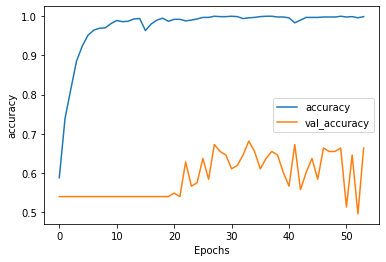

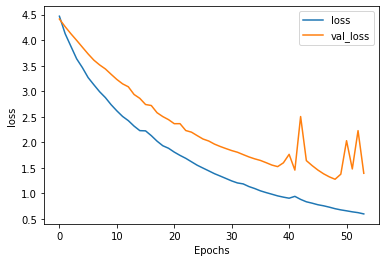

In [0]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(best_model, "accuracy")
plot_graphs(best_model, "loss")

In [0]:
# Use pre-trained Glove Embeddings

model3 = tf.keras.Sequential([hub.kerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim100/1", )])
model3.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))

Develop an n-gram CNN Model for Sentiment Analysis

In [0]:


def define_model(size2, length2, metrics):
  # channel 1
  inputs1 = Input(shape=(length2,))
  embedding1 = Embedding(size2, 150)(inputs1)
  conv1 = Conv1D(filters=32, kernel_size=2, activation='relu')(embedding1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)
  # channel 2
  inputs2 = Input(shape=(length2,))
  embedding2 = Embedding(size2, 150)(inputs2)
  conv2 = Conv1D(filters=32, kernel_size=3, activation='relu')(embedding2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)
  # channel 2
  inputs3 = Input(shape=(length2,))
  embedding3 = Embedding(size2, 150)(inputs3)
  conv3 = Conv1D(filters=32, kernel_size=4, activation='relu')(embedding3)
  drop3 = Dropout(0.5)(conv3)
  pool3 = MaxPooling1D(pool_size=2)(drop3)
  flat3 = Flatten()(pool3)
  # channel 3
  inputs4 = Input(shape=(4,))
  dense1 = Dense(4, activation="relu")(inputs4)
  drop4 = Dropout(0.5)(dense1)
  
  # merge
  merged = concatenate([flat1, flat2, flat3, drop4])
  # interpretation
  dense1 = Dense(10, activation='relu')(merged)
  outputs = Dense(1, activation='sigmoid')(dense1)
  model = Model(inputs=[inputs1, inputs2, inputs3, inputs4], outputs=outputs)
  # compile
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
  # summarize
  #model.summary()
  #plot_model(model, show_shapes=True, to_file='model.png')
  return model


tokenizer2 = Tokenizer(oov_token='<OOV>')
tokenizer2.fit_on_texts(x_train['motion_speech'])
length2 = max([len(sent.split()) for sent in x_train['motion_speech']])
train2 = tokenizer2.texts_to_sequences(x_train['motion_speech'])
train2 = pad_sequences(train2, padding='pre', maxlen=length2)
validation2 = tokenizer2.texts_to_sequences(x_val['motion_speech'])
validation2 = pad_sequences(validation2, padding='pre', maxlen=length2)

size2 = len(tokenizer2.word_index) + 1

In [0]:
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
model = define_model(size2, length2, metrics)
model.fit([train2,train2, train2, other_train], np.array(y_train), epochs=10, batch_size=50, validation_data=([validation2, validation2, validation2, other_val], y_val), shuffle=True)


Train on 1012 samples, validate on 113 samples
Epoch 1/10
1012/1012 [==============================] - 13s 13ms/sample - loss: 0.6964 - accuracy: 0.5692 - precision: 0.5761 - recall: 0.9589 - auc: 0.5155 - val_loss: 0.6912 - val_accuracy: 0.5929 - val_precision: 0.5929 - val_recall: 1.0000 - val_auc: 0.5003
Epoch 2/10
1012/1012 [==============================] - 11s 10ms/sample - loss: 0.6836 - accuracy: 0.5771 - precision: 0.5771 - recall: 1.0000 - auc: 0.5114 - val_loss: 0.6856 - val_accuracy: 0.5929 - val_precision: 0.5929 - val_recall: 1.0000 - val_auc: 0.5251
Epoch 3/10
1012/1012 [==============================] - 11s 10ms/sample - loss: 0.6494 - accuracy: 0.5771 - precision: 0.5771 - recall: 1.0000 - auc: 0.6845 - val_loss: 0.6558 - val_accuracy: 0.5929 - val_precision: 0.5929 - val_recall: 1.0000 - val_auc: 0.6517
Epoch 4/10
1012/1012 [==============================] - 11s 10ms/sample - loss: 0.5623 - accuracy: 0.5771 - precision: 0.5771 - recall: 1.0000 - auc: 0.9302 - val_loss

LSTM-CNN model

In [0]:
from tensorflow.keras.layers import LSTM

def define_model(length, vocab_size, size2, length2, metrics):
  # channel to train network using motion text
  inputs1 = Input(shape=(length,))
  embedding = Embedding(vocab_size, 150)(inputs1)
  conv = Conv1D(filters=32, kernel_size=2, activation='tanh')(embedding)
  pool = MaxPooling1D(pool_size=2)(conv)
  lstm1 = LSTM(30)(pool)
  out1 = Dense(10, activation='tanh')(lstm1)

  # channel 1
  inputs2 = Input(shape=(length2,))
  embedding1 = Embedding(size2, 150)(inputs2)
  conv1 = Conv1D(filters=32, kernel_size=2, activation='tanh')(embedding1)
  drop1 = Dropout(0.5)(conv1)
  pool1 = MaxPooling1D(pool_size=2)(drop1)
  flat1 = Flatten()(pool1)

  # channel 2
  inputs3 = Input(shape=(length2,))
  embedding2 = Embedding(size2, 150)(inputs3)
  conv2 = Conv1D(filters=32, kernel_size=3, activation='tanh')(embedding2)
  drop2 = Dropout(0.5)(conv2)
  pool2 = MaxPooling1D(pool_size=2)(drop2)
  flat2 = Flatten()(pool2)

  # channel 3
  inputs4 = Input(shape=(4,))
  dense1 = Dense(10, activation="relu")(inputs4)
  drop3 = Dropout(0.5)(dense1)
  
  # merge
  merged = concatenate([out1, flat1, flat2, drop3])
  # interpretation
  dense2 = Dense(10, activation='relu')(merged)
  outputs = Dense(1, activation='sigmoid')(dense2)
  model = Model(inputs=[inputs1, inputs2, inputs3, inputs4], outputs=outputs)
  # compile
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=metrics)
  # summarize
  #model.summary()
  #plot_model(model, show_shapes=True, to_file='model.png')
  return model


tokenizer2 = Tokenizer(oov_token='<OOV>')
tokenizer2.fit_on_texts(x_train['cleaned_motion'])
length1 = max([len(sent.split()) for sent in x_train['cleaned_motion']])
train1 = tokenizer2.texts_to_sequences(x_train['cleaned_motion'])
train1 = pad_sequences(train1, padding='pre', maxlen=length1)
validation1 = tokenizer2.texts_to_sequences(x_val['cleaned_motion'])
validation1 = pad_sequences(validation1, padding='pre', maxlen=length1)

size1 = len(tokenizer2.word_index) + 1

tokenizer2 = Tokenizer(oov_token='<OOV>')
tokenizer2.fit_on_texts(x_train['cleaned_speech'])
length2 = max([len(sent.split()) for sent in x_train['cleaned_speech']])
train2 = tokenizer2.texts_to_sequences(x_train['cleaned_speech'])
train2 = pad_sequences(train2, padding='pre', maxlen=length2)
validation2 = tokenizer2.texts_to_sequences(x_val['cleaned_speech'])
validation2 = pad_sequences(validation2, padding='pre', maxlen=length2)

size2 = len(tokenizer2.word_index) + 1

In [0]:
metrics = [ tf.keras.metrics.BinaryAccuracy(name='accuracy'), tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.AUC(name='auc')]
model = define_model(length1, size1, size2, length2, metrics)
model.fit([train1,train2, train2, other_train], y_train, epochs=10, batch_size=50, validation_data=([validation1, validation2, validation2, other_val], y_val), shuffle=True)


Train on 1012 samples, validate on 113 samples
Epoch 1/10
1012/1012 [==============================] - 13s 13ms/sample - loss: 0.6887 - accuracy: 0.5593 - precision: 0.5871 - recall: 0.7962 - auc: 0.5492 - val_loss: 0.6931 - val_accuracy: 0.4425 - val_precision: 0.6111 - val_recall: 0.1642 - val_auc: 0.5162
Epoch 2/10
1012/1012 [==============================] - 9s 9ms/sample - loss: 0.6704 - accuracy: 0.5830 - precision: 0.6278 - recall: 0.6815 - auc: 0.5870 - val_loss: 0.6669 - val_accuracy: 0.6018 - val_precision: 0.6038 - val_recall: 0.9552 - val_auc: 0.5999
Epoch 3/10
1012/1012 [==============================] - 9s 9ms/sample - loss: 0.6080 - accuracy: 0.6828 - precision: 0.6679 - recall: 0.8955 - auc: 0.7535 - val_loss: 0.6534 - val_accuracy: 0.5752 - val_precision: 0.6234 - val_recall: 0.7164 - val_auc: 0.6275
Epoch 4/10
1012/1012 [==============================] - 9s 9ms/sample - loss: 0.4702 - accuracy: 0.8024 - precision: 0.8009 - recall: 0.8750 - auc: 0.8738 - val_loss: 1.17